In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import math
import glob
import time
from datetime import date
from typing import Tuple, Union

import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm_notebook as tqdm
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from sklearn.model_selection import ShuffleSplit, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit


2024-12-12 00:00:36.884960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733961636.905538  138556 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733961636.911922  138556 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#--------------------- for working with directory ----------------------------
ROOT_DATA_PATH='/workspace/datasets'
DATASET_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection'

TRAIN_DATA_PATH=f'{DATASET_PATH}/stage_2_train'
TEST_DATA_PATH=f'{DATASET_PATH}/stage_2_test'
TRAIN_METADATA_PATH=f'{DATASET_PATH}/stage_2_train.csv'
TEST_METADATA_PATH=f'{DATASET_PATH}/stage_2_sample_submission.csv'
TRAIN_METADATA_SEQ_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/train_metadata_noidx.csv'
TEST_METADATA_SEQ_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/test_metadata_noidx.csv'

SEED = 666

In [3]:
#seeding
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
class ImagePreparationUtil:
    @staticmethod
    def correct_dcm(dcm: pydicom.FileDataset):
        x = dcm.pixel_array
        x = x + 1000
        px_mode = 4096
        x[x >= px_mode] = x[x >= px_mode] - px_mode
        dcm.PixelData = x.tobytes()
        dcm.RescaleIntercept = -1000
        
    @staticmethod
    def window_image(dcm: pydicom.FileDataset, window_center: int, window_width: int):
        if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
            ImagePreparationUtil.correct_dcm(dcm)
        
        # Pixel to Hounsfield Unit (HU)
        # HU=(Pixel Value×RescaleSlope)+RescaleIntercept
        img = dcm.pixel_array
        img = img * dcm.RescaleSlope + dcm.RescaleIntercept 
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)
        
        return img
    
    @staticmethod
    def get_windowed_image(dcm: pydicom.FileDataset, window: Union['brain', 'subdural', 'soft'] = 'brain') -> np.ndarray: # type: ignore
        im = None
        match window:
            case 'brain':
                brain_img = ImagePreparationUtil.window_image(dcm, 40, 80)
                brain_img = (brain_img - 0) / 80
                im = brain_img
            case 'subdural':
                subdural_img = ImagePreparationUtil.window_image(dcm, 80, 200)
                subdural_img = (subdural_img - (-20)) / 200
                im = subdural_img
            case 'soft':
                soft_img = ImagePreparationUtil.window_image(dcm, 40, 380)
                soft_img = (soft_img - (-150)) / 380
                im = soft_img
            case _:
                raise ValueError('invalid window argument')
        
        return im
    
    @staticmethod
    def bsb_window(dcm):
        brain_img = ImagePreparationUtil.get_windowed_image(dcm, window='brain')
        subdural_img = ImagePreparationUtil.get_windowed_image(dcm, window='subdural')
        soft_img = ImagePreparationUtil.get_windowed_image(dcm, window='soft')

        bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

        return bsb_img
    
    @staticmethod
    def read(path, resize: Tuple[int, int]):
        img = None
        try:
            dcm = pydicom.dcmread(path)
            img = ImagePreparationUtil.bsb_window(dcm)
        except Exception as e:
            print('\nWarning:', e.__class__.__name__, f'for {path} Replacing with zeros image')
            img = np.zeros((*tuple(resize[:2]), 3), dtype=np.float32)
        
        if resize is not None:
            img = cv2.resize(img, resize[:2], interpolation=cv2.INTER_LINEAR)
            
        return img.astype(np.float32)

In [5]:
class MetadataLoader:
    def __init__(self, train_metadata_path = TRAIN_METADATA_PATH, test_metadata_path = TEST_METADATA_PATH, lazy_load = True):
      self.train_metadata_path = train_metadata_path
      self.test_metadata_path = test_metadata_path
      self._lazy_load = lazy_load
      self._train_df = None
      self._test_df = None
      
      if not self._lazy_load:
        self._load_trainset()
        self._load_testset()
        
    def _read(self, is_read_train_metadata = True):
        csv_file = self.train_metadata_path
        if not is_read_train_metadata:
            csv_file = self.test_metadata_path
            
        df = pd.read_csv(csv_file)
        
        df["Image"] = df["ID"].str.slice(stop=12)
        df["Diagnosis"] = df["ID"].str.slice(start=13)
        
        if is_read_train_metadata:
            duplicates_to_remove = [
                56346, 56347, 56348, 56349,
                56350, 56351, 1171830, 1171831,
                1171832, 1171833, 1171834, 1171835,
                3705312, 3705313, 3705314, 3705315,
                3705316, 3705317, 3842478, 3842479,
                3842480, 3842481, 3842482, 3842483
            ]
            df = df.drop(index=duplicates_to_remove)
            df = df.reset_index(drop=True)
        
        df = df.loc[:, ['Label', 'Diagnosis', 'Image']]
        df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
        
        return df
    
    def sync_with_actual_file(self):
        """
        Some files maybe didn't contain legitimate images, so we need to remove them from dataframe if any
        """
        if self._train_df is None:
            self._load_trainset()
        
        dcms = glob.glob(os.path.join(TRAIN_DATA_PATH, '*.dcm'))
        dcms = [os.path.basename(dcm)[:-4] for dcm in dcms]
        
        self._train_df = self._train_df[self._train_df.index.isin(dcms)]

    def _load_trainset(self):
        self._train_df = self._read(is_read_train_metadata=True)
    
    def _load_testset(self):
        self._test_df = self._read(is_read_train_metadata=False)
    
    def reload_set(self):
        self._load_trainset()
        self._load_testset()
    
    @property
    def train_df(self):
        if self._train_df is not None:
            return self._train_df
        self._load_trainset()
        return self._train_df
    
    @property
    def test_df(self):
        if self._test_df is not None:
            return self._test_df
        self._load_testset()
        return self._test_df

In [6]:
def plot_data_distribution(df, legend_suptitle):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(legend_suptitle)
    sns.countplot(data=df['Label'], x='any', hue='any',  ax=axes[0], palette='Reds')
    axes[0].set_title("Distribution of ICH Diagnoses (Positive vs Negative)")
    axes[0].set_xlabel("ICH Diagnosis (0=Negative, 1=Positive)")
    axes[0].set_ylabel('Count')
    for c in axes[0].containers:
        axes[0].bar_label(c , fmt=lambda x: f'{(x/df["Label"]["any"].count())*100:0.1f}%')

    df_label_counts = df['Label'].sum(axis=0)[1:].reset_index()
    df_label_counts.columns = ['Label', 'Count']
        
    sns.barplot(x='Label', y='Count', data=df_label_counts, hue='Label' , palette='Set2')
    axes[1].set_title('Percentage of Positive Occurrences by ICH Type')
    axes[1].set_xlabel('ICH Type')
    axes[1].set_ylabel('Positive Occurrence (%)')
    plt.setp(axes[1].get_xticklabels(), rotation=45)
    for c in axes[1].containers:
        axes[1].bar_label(c ,fmt=lambda x: f'{x/len(df.index)*100:0.01f}%')

In [7]:
df_loader = MetadataLoader()
df = df_loader.train_df
df

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000012eaf     0        0                0                0            0   
ID_000039fa0     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   
ID_00008ce3c     0        0                0                0            0   
ID_0000950d7     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_ffff82e46     0        0                0                0            0   
ID_ffff922b9     1        0                0                1            0   
ID_ffffb670a     1        0                0                0            1   
ID_ffffcbff8     0        0                0                0            0   
ID_fffff9393     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_000012eaf        0  
ID_000039fa0        0  
ID_00005679d        0  
ID_00008ce3c        0  
ID_0000950d7        0  
...               ...  
ID_ffff82e46        0  
ID_ffff922b9        0  
ID_ffffb670a        0  
ID_ffffcbff8        0  
ID_fffff9393        0  

[752803 rows x 6 columns]

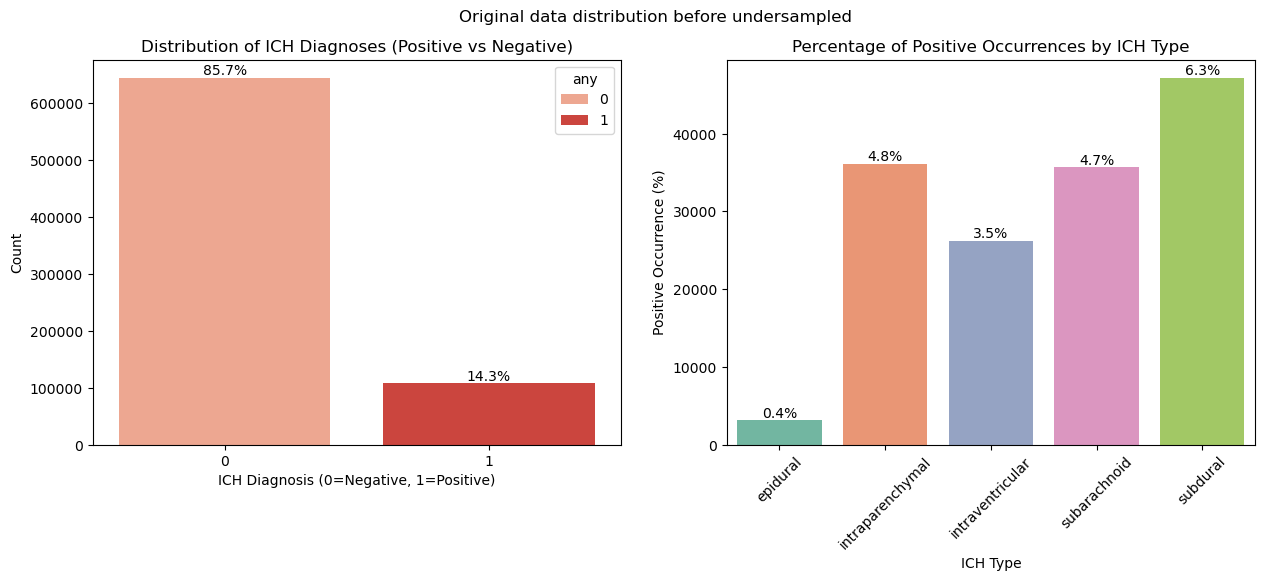

In [8]:
plot_data_distribution(df, 'Original data distribution before undersampled')

In [9]:
df['Label']['any'].value_counts()

any
0    644870
1    107933
Name: count, dtype: int64

In [10]:
num_positive_diag = df['Label'][df['Label']['any'] == 1].shape[0]
df_negative_diag_selection = df[df['Label']['any'] == 0].sample(n=int(num_positive_diag), replace=False)
df_negative_diag_selection

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_29f852fa1     0        0                0                0            0   
ID_324ad996b     0        0                0                0            0   
ID_de3f846d2     0        0                0                0            0   
ID_7ff46b6e6     0        0                0                0            0   
ID_f410172f9     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_791ef7020     0        0                0                0            0   
ID_6b512e2f5     0        0                0                0            0   
ID_f0efa4b0b     0        0                0                0            0   
ID_2b883eb14     0        0                0                0            0   
ID_7668eaad8     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_29f852fa1        0  
ID_324ad996b        0  
ID_de3f846d2        0  
ID_7ff46b6e6        0  
ID_f410172f9        0  
...               ...  
ID_791ef7020        0  
ID_6b512e2f5        0  
ID_f0efa4b0b        0  
ID_2b883eb14        0  
ID_7668eaad8        0  

[107933 rows x 6 columns]

In [11]:
df = df[(df['Label']['any'] == 1) | df.index.isin(df_negative_diag_selection.index.values)]
df = df.sample(frac=1)
df

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_d119d112e     0        0                0                0            0   
ID_15929fc09     1        0                0                0            0   
ID_3545d4f76     1        0                0                1            0   
ID_4ec645046     0        0                0                0            0   
ID_0f19fb28b     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_849d33f57     1        0                0                1            1   
ID_01562df58     1        0                0                1            0   
ID_718816bca     0        0                0                0            0   
ID_7f199f5bd     1        0                0                1            0   
ID_98018c310     1        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_d119d112e        0  
ID_15929fc09        1  
ID_3545d4f76        0  
ID_4ec645046        0  
ID_0f19fb28b        0  
...               ...  
ID_849d33f57        0  
ID_01562df58        0  
ID_718816bca        0  
ID_7f199f5bd        0  
ID_98018c310        1  

[215866 rows x 6 columns]

In [12]:
df['Label']['any'].value_counts()

any
0    107933
1    107933
Name: count, dtype: int64

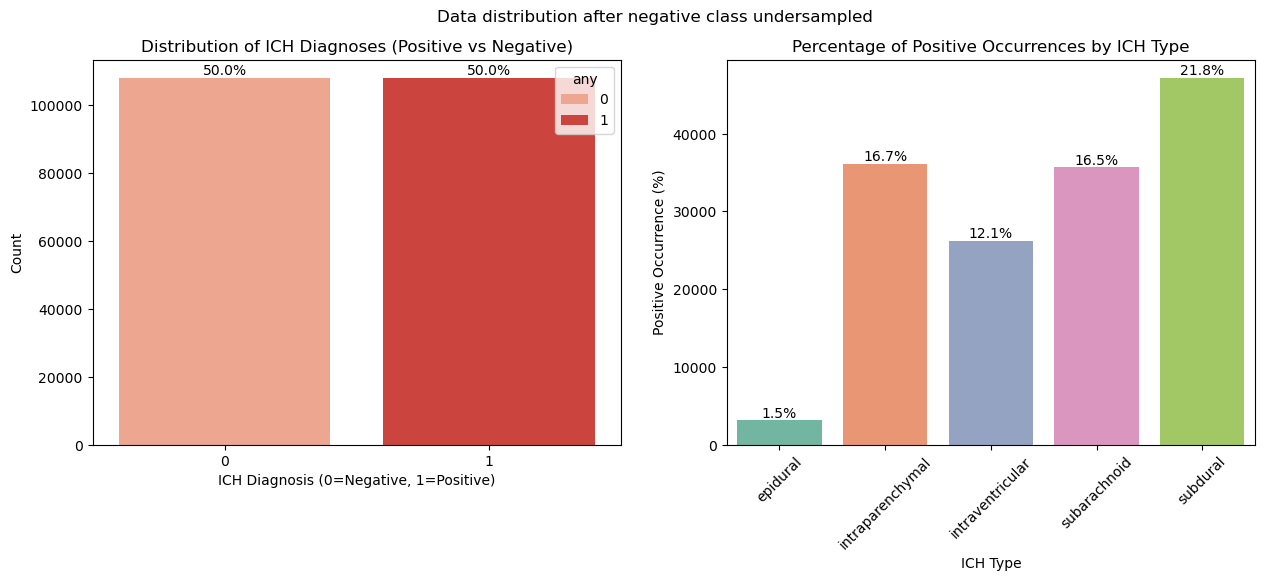

In [13]:
plot_data_distribution(df, 'Data distribution after negative class undersampled')

In [14]:
class TrainDataGenerator(keras.utils.Sequence):
    def __init__(self, img_ids, labels, img_dir, img_shape, num_classes, batch_size, under_sampling=False, shuffle_on_epoch_end=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.img_ids = img_ids
        self.labels = labels
        self.img_dir = img_dir
        self.img_shape = img_shape
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.under_sampling = under_sampling
        self.shuffle_on_epoch_end = shuffle_on_epoch_end
        self.on_epoch_end()
    
    def __len__(self):
        return math.ceil(len(self.img_ids) / self.batch_size)

    def __getitem__(self, index):
        low = index*self.batch_size
        high = min(low + self.batch_size, len(self.img_ids))
        indices = self.indices[low:high]
        X,y = self.__data_generation(indices)

        return X,y
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.img_ids))
        
        if self.under_sampling:
            keep_prob = self.labels.iloc[:,0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = self.indices[keep]
            
        if self.shuffle_on_epoch_end:
            np.random.shuffle(self.indices)

        
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_shape))
        y = np.empty((self.batch_size, self.num_classes), dtype=np.float32)
        
        for i, img_idx in enumerate(indices):
            img_id = self.img_ids[img_idx]
            img_path = f'{self.img_dir}/{img_id}.dcm'
            img = ImagePreparationUtil.read(img_path, self.img_shape[:2])
            X[i,] = img
            y[i,] = self.labels.iloc[img_idx].values
            
        return X,y
         

In [ ]:
class DeepModel():
    def __init__(self, base,input_shape, batch_size, num_epochs, num_classes, learning_rate, decay_rate, decay_steps, base_name='base_model', weights='imagenet', freeze_base=False, saving_path=None, verbose=1):
        self.base = base
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.base_name = base_name
        self.weights = weights
        self.freeze_base = freeze_base
        self.saving_path = saving_path
        self.verbose = verbose
        self._build()
        self._create_saving_path_if_none()
    
    def _build(self):
        K.clear_session()
        base = self.base(include_top=False, weights=self.weights, pooling='avg', input_shape=self.input_shape)
        base.trainable = not self.freeze_base
            
        x = base.output
        # x = layers.Dense(512, activation='relu', name='hidden_layer_1')(x)
        # x = layers.Dropout(0.4)(x)
        # x = layers.Dense(512, activation='relu', name='hidden_layer_2')(x)
        # x = layers.Dropout(0.6)(x)
        # x = layers.Dense(512, activation='relu', name='hidden_layer_3')(x)
        x = layers.Dropout(0.2)(x)
        out = layers.Dense(self.num_classes, activation='sigmoid', name='dense_output')(x)
        
        self.model = keras.models.Model(inputs=base.input, outputs=out)
        
        
        self.model.compile(
            loss=keras.losses.BinaryCrossentropy(), 
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            metrics=[
                keras.metrics.BinaryAccuracy(),
                keras.metrics.TruePositives(),
                keras.metrics.TrueNegatives(),
                keras.metrics.FalsePositives(),
                keras.metrics.FalseNegatives(),
                keras.metrics.Precision(),
                keras.metrics.Recall(),
                keras.metrics.AUC(name='auc_roc', curve='ROC'),
                keras.metrics.AUC(name='auc_pr', curve='PR'),
                keras.metrics.F1Score(name='f1_score'),
            ]
        )
        
    def _create_saving_path_if_none(self):
        if self.saving_path is None:
            print('saving_path is None. Automatically create path for save training utilities')
            saving_path = os.path.join('saved_model', self.base.__name__)
            os.makedirs(saving_path, exist_ok=True)
            self.saving_path = saving_path
            print(self.saving_path, 'created for saving_path')
        else:
            os.makedirs(self.saving_path, exist_ok=True)
            print('saving_path: ', self.saving_path)
            
        
    def fit(self, train_df, valid_df):
        train_data_gen = TrainDataGenerator(
            img_ids=train_df.index, 
            labels=train_df,
            img_dir=TRAIN_DATA_PATH,
            img_shape=self.input_shape,
            num_classes=self.num_classes,
            batch_size=self.batch_size,
            under_sampling=False,
            workers=128,
            use_multiprocessing=True
        )
        
        valid_data_gen = TrainDataGenerator(
            img_ids=valid_df.index, 
            labels=valid_df,
            img_dir=TRAIN_DATA_PATH,
            img_shape=self.input_shape,
            num_classes=self.num_classes,
            batch_size=self.batch_size,
            under_sampling=False,
            workers=128,
            use_multiprocessing=True
        )
        
        curr_time = int(time.time())
        callbacks = [
            keras.callbacks.ModelCheckpoint(filepath='%s/{epoch:02d}-%s.weights.h5' % (self.saving_path, curr_time), monitor='val_loss', mode='min', verbose=self.verbose, save_weights_only=True, save_best_only=True),
            keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, math.floor(epoch / self.decay_steps)), verbose=1),
            keras.callbacks.EarlyStopping(verbose=1, restore_best_weights=True, monitor='val_loss', patience=3, mode='min'),
            keras.callbacks.CSVLogger(filename='%s/%s.csv'%(self.saving_path, f'{curr_time}-train_log'))
        ]
        
        # class_weight = generate_class_weights(train_df.to_numpy(), multi_class=False, one_hot_encoded=True)
        return self.model.fit(
            x=train_data_gen,
            validation_data=valid_data_gen,
            callbacks=callbacks,
            epochs=self.num_epochs,
            verbose=self.verbose
        )
    
    def save(self, filename, overwrite=True):
        _, ext = os.path.splitext(filename)
        if ext != '.keras':
          filename = f'{filename}.keras'
          
        p = os.path.join(self.saving_path, filename)
        self.model.save(p, overwrite=overwrite)
        print('model saved to:', p)
        
    def load_weights(self, path, *args, **kwargs):
        self.model.load_weights(path, *args, **kwargs)
        
    def load(self, path, *args, **kwargs):
        self.model = keras.models.load_model(path, *args, **kwargs)
        

In [17]:
EPOCH = 12
INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 64
N_CLASSES = 1

In [18]:
# let's try for binary classification (1 = ICH presence, 0 = ICH not presence)
df = df.drop(columns=df.columns[1:], axis=1)
df

,Label
Diagnosis,any
Image,
ID_d119d112e,0
ID_15929fc09,1
ID_3545d4f76,1
ID_4ec645046,0
ID_0f19fb28b,0
...,...
ID_849d33f57,1
ID_01562df58,1


In [19]:
test_df_neg = df[df['Label']['any'] == 0].sample(n=200)
test_df_pos = df[df['Label']['any'] == 1].sample(n=200)
test_df = pd.concat([test_df_pos, test_df_neg]).sample(frac=1)

In [20]:
df = df.drop(test_df.index)
df.value_counts()

(Label, any)
0               107733
1               107733
Name: count, dtype: int64

In [ ]:
model = DeepModel(
    base=keras.applications.EfficientNetB4,
    weights='imagenet',
    freeze_base=False,
    input_shape=INPUT_SHAPE, 
    batch_size=BATCH_SIZE, 
    num_epochs=EPOCH,
    num_classes=N_CLASSES,
    learning_rate=0.00125, 
    decay_rate=0.5, 
    decay_steps=1,
    base_name='efficientnetb4_binary',
    saving_path='saved_model/efficientnetb4_binary'
)

I0000 00:00:1733962163.393008  138556 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8225 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.10gb, pci bus id: 0000:07:00.0, compute capability: 8.0


saving_path:  saved_model/efficientnetb4_binary


In [22]:
ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED).split(df.index)
# lets go for first fold only
train_idx, valid_idx = next(ss)

In [ ]:
hist = model.fit(df.iloc[train_idx], df.iloc[valid_idx])


Epoch 1: LearningRateScheduler setting learning rate to 0.00125.
Epoch 1/12


I0000 00:00:1733962294.812142  139105 service.cc:148] XLA service 0x7f59440032d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733962294.812184  139105 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.10gb, Compute Capability 8.0
I0000 00:00:1733962303.166032  139105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1733962373.234189  139105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1114/2694 ━━━━━━━━━━━━━━━━━━━━ 18:29 702ms/step - auc_pr: 0.9149 - auc_roc: 0.9112 - binary_accuracy: 0.8310 - f1_score: 0.6678 - false_negatives: 2943.9775 - false_positives: 2416.0269 - loss: 0.3691 - precision: 0.8400 - recall: 0.8214 - true_negatives: 15415.2041 - true_positives: 14904.7920
2694/2694 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - auc_pr: 0.9354 - auc_roc: 0.9323 - binary_accuracy: 0.8565 - f1_score: 0.6670 - false_negatives: 6090.9653 - false_positives: 5012.9058 - loss: 0.3246 - precision: 0.8657 - recall: 0.8452 - true_negatives: 38121.7734 - true_positives: 37014.3594
Epoch 1: val_loss improved from inf to 5.50526, saving model to saved_model/efficientnetb4_binary/01-1733962195.weights.h5
2694/2694 ━━━━━━━━━━━━━━━━━━━━ 2572s 889ms/step - auc_pr: 0.9354 - auc_roc: 0.9323 - binary_accuracy: 0.8565 - f1_score: 0.6670 - false_negatives: 6092.8237 - false_positives: 5014.4785 - loss: 0.3245 - precision: 0.8657 - recall: 0.8452 - true_negatives: 38136.1719 - true_positives: 370

In [ ]:
model.save('final_efficientnetb4_binary.keras')